In [296]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [287]:
class Board:
    def __init__(self):
        self.reset_board()
        
    def turn(self, player, loc):
        if self.winner is not None:
            raise Exception("The game is currently won by player %s." % self.winner)
        
        if player != self.player_turn:
            raise Exception("It is player %s's turn." % self.player_turn)
        
        if self.area[loc] != -1:
            raise Exception('Space %s is already claimed by player %s.' % (loc, self.area[loc]))
            
        self.area[loc] = player
        self.move_rcd.append((player, loc))
        self.win_check()
        
        self.player_turn = (self.player_turn + 1) % 2
        
    def win_check(self):
        for player in (0, 1):
            for i in range(3):
                if np.all(self.area[i,:] == player):
                    self.winner = player
                    
            for i in range(3):
                if np.all(self.area[:,i] == player):
                    self.winner = player
                    
            if np.all(np.array([self.area[i,i] for i in range(3)]) == player):
                self.winner = player
                
            if np.all(np.array([self.area[i,2-i] for i in range(3)]) == player):
                self.winner = player
                
        if np.all(self.area != -1):
            self.winner = 'draw'
    
    @property
    def free_moves(self):
        moves = []
        if self.winner is None:
            for i in range(3):
                for j in range(3):
                    if self.area[i,j] == -1:
                        moves.append((i,j))
        
        return moves
    
    def reset_board(self):
        self.area = np.zeros((3,3)).astype(int) - 1
        self.player_turn = 0
        self.winner = None
        self.move_rcd = []

In [288]:
class PlayerRand:
    def __init__(self, player_num):
        self.player_num = player_num
        
    def make_move(self, board):
        moves = self.check_moves(board)
        if len(moves) > 0:
            move = moves[np.random.choice(np.arange(len(moves)))]
            board.turn(self.player_num, move)
        
    def check_moves(self, board):
        moves = board.free_moves
        return moves
    
    def new_game(self):
        pass

In [289]:
class PlayerLearn(PlayerRand):
    def __init__(self, player_num):
        super().__init__(player_num)
        self.learn_tree = {}
        self.move_record = []
        self.win = None
        
    def make_move(self, board):
        moves = self.check_moves(board)
        if len(moves) > 0:
            if self.learn_tree.get(str(moves), None) is None:
                self.learn_tree[str(moves)] = {
                    'successes': np.zeros(len(moves)),
                    'attempts': np.zeros(len(moves))
                }
                probs = np.array([1/len(moves)] * len(moves))
            else:
                numer = self.learn_tree[str(moves)]['successes']
                denom = self.learn_tree[str(moves)]['attempts']
                probs = numer / denom
                probs[pd.isnull(probs)] = 1 / len(moves)
                if probs.sum() == 0:
                    probs = np.array([1/len(moves)] * len(moves))
                else:
                    probs /= probs.sum()
                
            move = moves[np.random.choice(np.arange(len(moves)), p = probs)]
            self.move_record.append((moves, moves.index(move)))
            board.turn(self.player_num, move)
        else:
            if board.winner == self.player_num:
                self.win = True
            elif board.winner == 'draw':
                self.win = 'draw'
            
    def new_game(self):
        for moves, move_idx in self.move_record:
            self.learn_tree[str(moves)]['attempts'][move_idx] += 1
            if self.win is True: success = 1
            elif self.win == 'draw': success = 0.5
            else: success = 0
            self.learn_tree[str(moves)]['successes'][move_idx] += success
            
        self.move_record = []
        self.win = None

In [299]:
board = Board()

In [300]:
player_1 = PlayerLearn(0)
player_2 = PlayerLearn(1)
play_rcd = []
stats_rcd = []

In [301]:
t = tqdm.tnrange(1000)
for i in t:
    while board.winner is None:
        player_1.make_move(board)
        player_2.make_move(board)
    play_rcd.append(board.winner)
    board.reset_board()
    player_1.new_game()
    player_2.new_game()
    stats = (pd.Series(play_rcd).value_counts() / len(play_rcd))
    stats_rcd.append(stats)
    stats = stats.to_dict()
    t.set_postfix({'win': stats.get(0, 0), 'loss': stats.get(1, 0), 'draw': stats.get('draw', 0)})

/home/calvinxc1/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


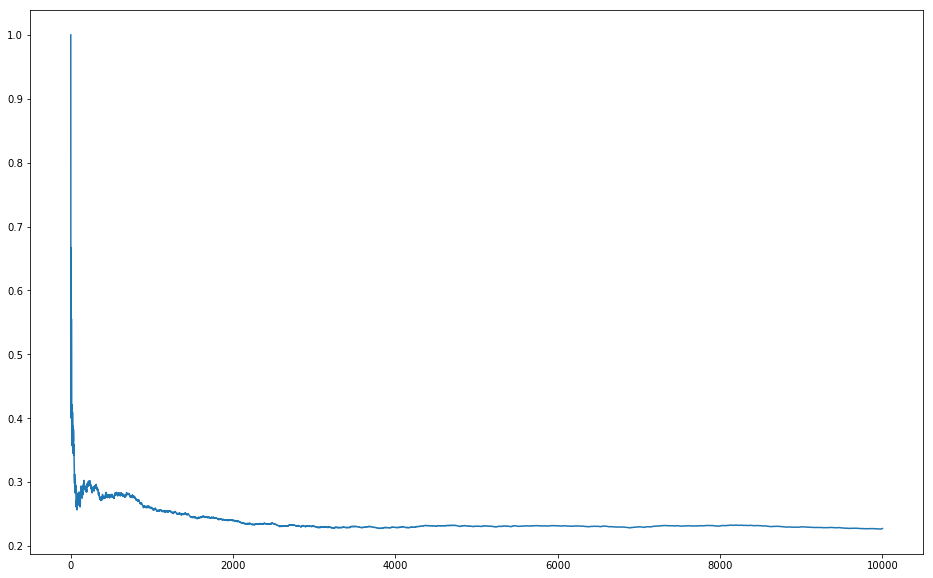

In [304]:
plt.figure(figsize=(16,10))
plt.plot([stat.to_dict().get(1, 0) for stat in stats_rcd])